In [1]:
import os
import functools
import numpy as np
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
img_size = 256
channel = 3

In [3]:
def get_label(file_path, labels):
    parts = tf.strings.split(file_path, os.path.sep)[-1]
    label = tf.strings.regex_replace(parts, '(\.png|\.jpg|\.jpeg|[0-9]|_)', '')
    one_hot_label = tf.cast(tf.math.equal(tf.constant(labels), label), tf.float32)    
    return one_hot_label

def augmentation(image):
    image = tf.image.resize(image, [img_size, img_size], preserve_aspect_ratio=False)
    image = tf.cast(image, tf.float32) / 255.
    return image

def load_images(file_path, labels):
    label = get_label(file_path, labels)
    img = tf.io.decode_jpeg(tf.io.read_file(file_path), channels=channel)
    img = augmentation(img)
    return img, label

In [4]:
def create_dataset(dir_root, batch_size, labels):
    train_dir = dir_root+'train/'
    test_dir = dir_root+'test/'
    
    train_ds = tf.data.Dataset.list_files(str(train_dir+'*.*'))
    test_ds = tf.data.Dataset.list_files(str(test_dir+'*.*'))

    load_images_partial = functools.partial(load_images, labels=labels)
    
    train_ds = train_ds.map(load_images_partial, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(train_ds.cardinality()).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_ds = test_ds.map(load_images_partial, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return train_ds, test_ds

In [5]:
def plot_image(dataset, index, labels):
    ds = dataset.take(1).get_single_element()
    plt.imshow(ds[0][index], cmap=plt.cm.gray, interpolation='nearest')
    plt.title("LABEL: %s" % tf.gather(labels, tf.argmax(ds[1][index].numpy())).numpy().decode('utf-8') )
    plt.show()
    print()
    return

def plot_images(batch_size, labels, train_ds, test_ds):
    index = np.random.randint(0, batch_size, (1,))[0]
    print('A sample of test set: ')
    plot_image(test_ds, index, labels)

    print('A sample of train set: ')
    plot_image(train_ds, index, labels)
    

def plot_loss_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    return

def plot_accuracy_curve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    return

def plot_confusion_matrix(model, dataset, classes, test_steps):
    y_test_preds = model.predict(dataset, steps=test_steps)
    y_test_preds = np.argmax(y_test_preds, axis=1)
    y_test = np.concatenate([y for x, y in dataset], axis=0)
    y_test = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test, y_test_preds, labels=[i for i in range(len(classes))])
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.colorbar()
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

In [6]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor, threshold, max_epochs, patience=3):
        super(EarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.threshold = threshold
        self.best_weights = None
        self.max_epochs = max_epochs
        self.best_monitoring_value = float('-inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_monitoring_value = logs.get(self.monitor)
        if current_monitoring_value is None:
            raise ValueError(f"The metric {self.monitor} is not available in logs for early stopping.")
        if epoch >= self.max_epochs - 1:
            print(f"\n--- Early stopping: Reached maximum number of epochs : {self.max_epochs} \n")
            self.model.set_weights(self.best_weights)
            self.model.stop_training = True
            return
        if current_monitoring_value > self.best_monitoring_value:
            self.best_weights = self.model.get_weights()
            self.best_monitoring_value = current_monitoring_value
        if current_monitoring_value < self.threshold:
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.set_weights(self.best_weights)
                self.model.stop_training = True
                print(f"\n--- Early stopping: {self.monitor} has been more than {self.threshold} for {self.patience} epochs.\n")
                return

In [7]:
class CustomCNN:

    def __CustomCNN(self, input_shape):
        input_layer = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        
        return tf.keras.models.Model(inputs=input_layer, outputs=x, name='CustomCNN')
    
    def create_model(self, input_shape, num_classes):
        base_model = self.__CustomCNN(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)
        fc = tf.keras.layers.Dense(512, activation='relu')(fc)
        fc = tf.keras.layers.Dropout(0.3)(fc)
        fc = tf.keras.layers.Dense(num_classes, activation='softmax')(fc)
        return tf.keras.models.Model(inputs=base_model.input, outputs=fc, name='CustomCNN-Classifier')

# ACDC

A sample of test set: 


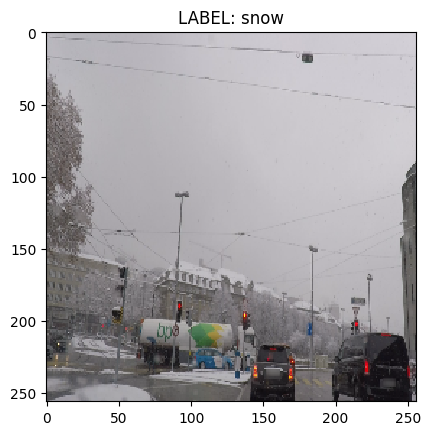


A sample of train set: 


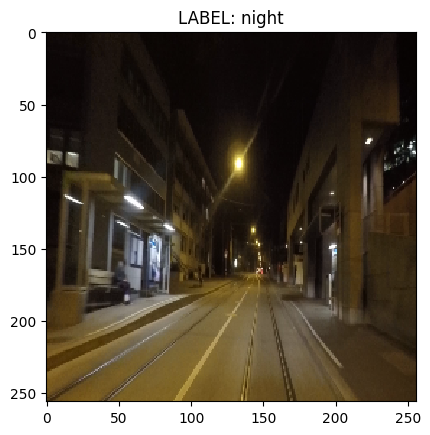

In [9]:
batch_size = 32
labels = ['clear', 'fog', 'night', 'rain', 'snow']
dir_root = '/kaggle/input/weather-datasets/ACDC/ACDC/'
train_ds, test_ds = create_dataset(dir_root = dir_root, batch_size = batch_size, labels = labels)
plot_images(batch_size, labels, train_ds, test_ds)
train_steps = int(tf.data.experimental.cardinality(train_ds).numpy())
test_steps = int(tf.data.experimental.cardinality(test_ds).numpy())

In [10]:
customcnn = CustomCNN().create_model(input_shape=(img_size, img_size, channel), num_classes = len(labels))

MAX_EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.90, max_epochs=MAX_EPOCHS, patience=5)

customcnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [11]:
customcnn_history = customcnn.fit(train_ds, epochs = MAX_EPOCHS, validation_data=test_ds, callbacks=[early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/50
32/32 [==============================] - 11s 164ms/step - loss: 1.4702 - accuracy: 0.4810 - precision: 0.5290 - recall: 0.4100 - val_loss: 1.5941 - val_accuracy: 0.2060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
32/32 [==============================] - 2s 68ms/step - loss: 0.6882 - accuracy: 0.7470 - precision: 0.7830 - recall: 0.7000 - val_loss: 1.6193 - val_accuracy: 0.3160 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
32/32 [==============================] - 2s 64ms/step - loss: 0.5394 - accuracy: 0.8130 - precision: 0.8394 - recall: 0.7790 - val_loss: 1.6307 - val_accuracy: 0.3060 - val_precision: 0.5000 - val_recall: 0.0040
Epoch 4/50
32/32 [==============================] - 2s 69ms/step - loss: 0.4108 - accuracy: 0.8400 - precision: 0.8636 - recall: 0.8170 - val_loss: 1.6430 - val_accuracy: 0.3220 - val_precision: 0.5333 - val_recall: 0.0160
Epoch 5/50
32/32 [==============================] - 2s 68ms/step - loss: 0.3262 - accuracy

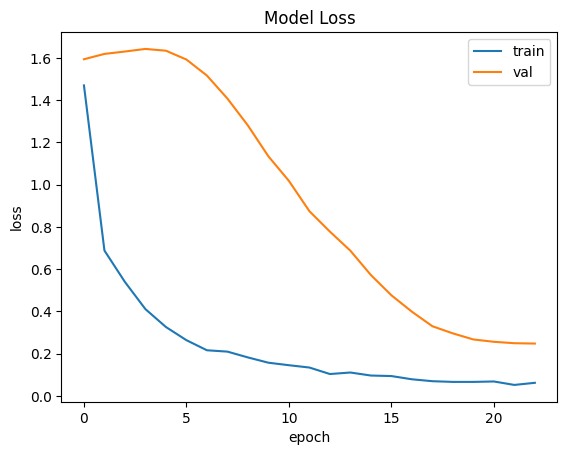

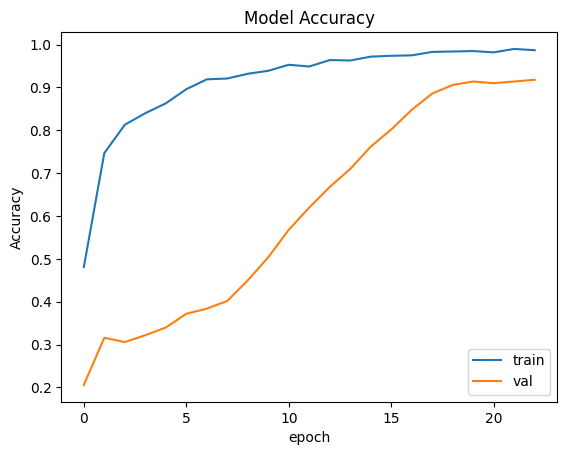

16/16 [==============================] - 0s 20ms/step


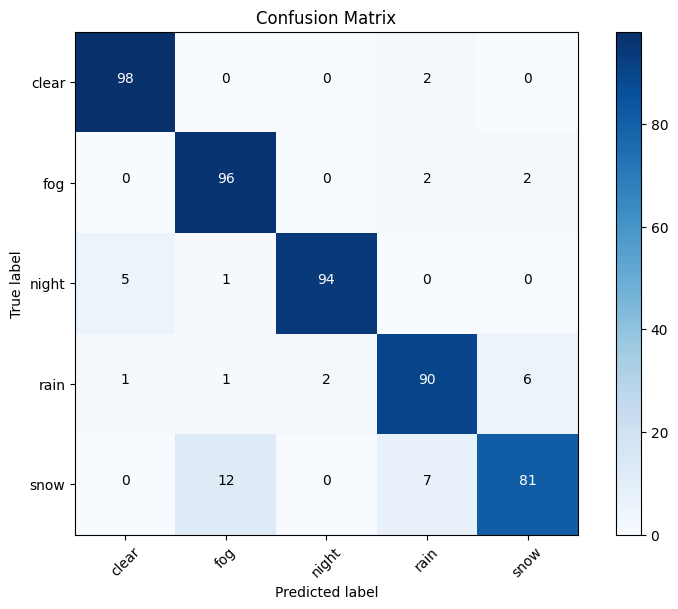

16/16 [==============================] - 0s 22ms/step - loss: 0.2479 - accuracy: 0.9180 - precision: 0.9229 - recall: 0.9100
Custom CNN classifier evaluation results:

Testset Loss = 0.24787
Testset Accuracy = 0.92
Testset Precision = 0.92
Testset Recall = 0.91


In [12]:
plot_loss_curve(customcnn_history)
plot_accuracy_curve(customcnn_history)
plot_confusion_matrix(customcnn,test_ds,labels, test_steps)
customcnn_score = customcnn.evaluate(test_ds, verbose='auto', steps=test_steps)
print("Custom CNN classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(customcnn_score[0]))
print('Testset Accuracy = {:.2f}'.format(customcnn_score[1]))
print('Testset Precision = {:.2f}'.format(customcnn_score[2]))
print('Testset Recall = {:.2f}'.format(customcnn_score[3]))

# MWD

In [13]:
from PIL import Image
import os

def convert_images(path):
    save_path = '/kaggle/working/MWD/'+path
    os.makedirs(save_path, exist_ok=True)
    root_path = '/kaggle/input/weather-datasets/MWD/MWD/'
    folder_path = root_path + path
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            img.convert('RGB').save(os.path.join(save_path, f"{os.path.splitext(filename)[0]}.jpg"), 'JPEG')
            
convert_images('train')
convert_images('test')

A sample of test set: 


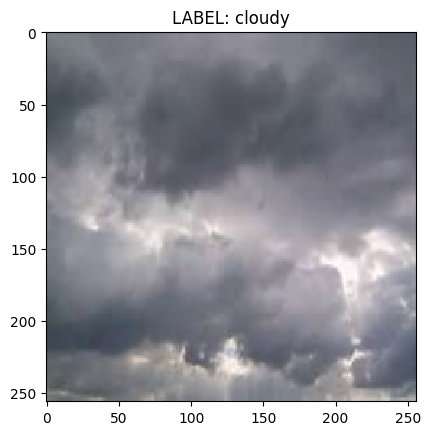


A sample of train set: 


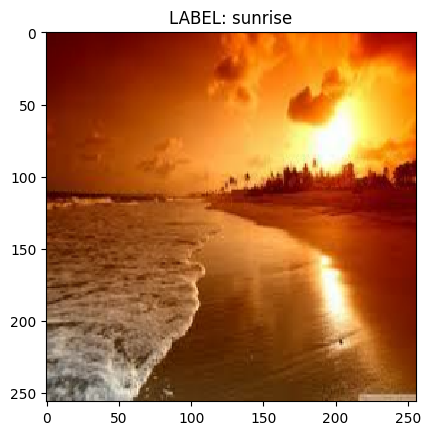

In [14]:
batch_size = 16
labels = ['sunrise', 'shine', 'cloudy', 'rain']
dir_root = '/kaggle/working/MWD/'
# dir_root = '/kaggle/input/weather-datasets/MWD/MWD/'
train_ds, test_ds = create_dataset(dir_root = dir_root, batch_size = batch_size, labels = labels)
plot_images(batch_size, labels, train_ds, test_ds)
train_steps = int(tf.data.experimental.cardinality(train_ds).numpy())
test_steps = int(tf.data.experimental.cardinality(test_ds).numpy())

In [15]:
customcnn = CustomCNN().create_model(input_shape=(img_size, img_size, channel), num_classes = len(labels))

MAX_EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.90, max_epochs=MAX_EPOCHS, patience=5)

customcnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [16]:
customcnn_history = customcnn.fit(train_ds, epochs = MAX_EPOCHS, validation_data=test_ds, callbacks=[early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/50
53/53 [==============================] - 7s 54ms/step - loss: 1.4400 - accuracy: 0.4923 - precision_1: 0.5296 - recall_1: 0.4333 - val_loss: 1.3602 - val_accuracy: 0.2698 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
53/53 [==============================] - 2s 35ms/step - loss: 0.7045 - accuracy: 0.7473 - precision_1: 0.7782 - recall_1: 0.7084 - val_loss: 1.3965 - val_accuracy: 0.2698 - val_precision_1: 0.4959 - val_recall_1: 0.2158
Epoch 3/50
53/53 [==============================] - 2s 35ms/step - loss: 0.5083 - accuracy: 0.8205 - precision_1: 0.8472 - recall_1: 0.7922 - val_loss: 1.3962 - val_accuracy: 0.2698 - val_precision_1: 0.2809 - val_recall_1: 0.2698
Epoch 4/50
53/53 [==============================] - 2s 37ms/step - loss: 0.4191 - accuracy: 0.8501 - precision_1: 0.8632 - recall_1: 0.8194 - val_loss: 1.3157 - val_accuracy: 0.2806 - val_precision_1: 0.3000 - val_recall_1: 0.2698
Epoch 5/50
53/53 [==============================] - 2s 38ms/step - l

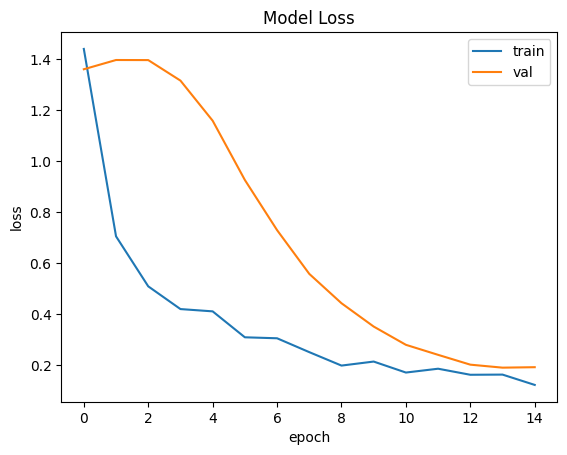

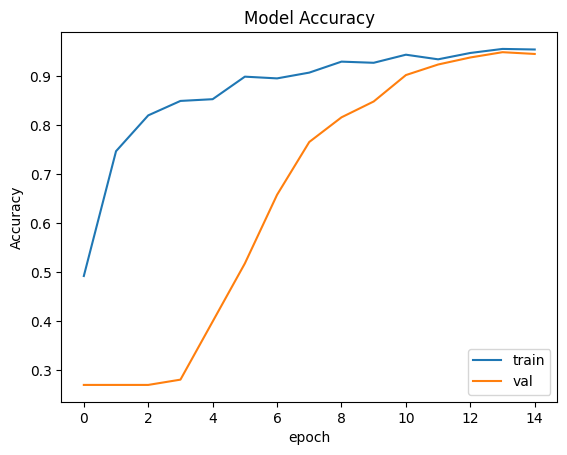

18/18 [==============================] - 0s 10ms/step


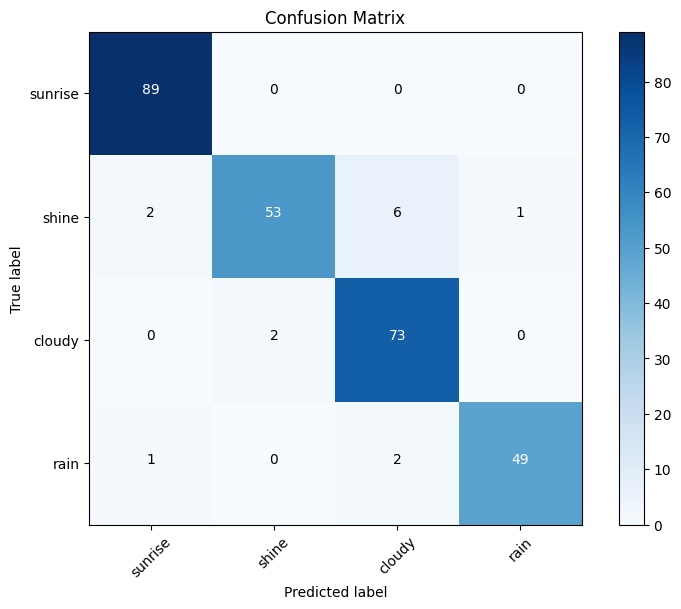

18/18 [==============================] - 0s 13ms/step - loss: 0.1892 - accuracy: 0.9496 - precision_1: 0.9596 - recall_1: 0.9388
Custom CNN classifier evaluation results:

Testset Loss = 0.18921
Testset Accuracy = 0.95
Testset Precision = 0.96
Testset Recall = 0.94


In [18]:
plot_loss_curve(customcnn_history)
plot_accuracy_curve(customcnn_history)
plot_confusion_matrix(customcnn,test_ds,labels, test_steps)
customcnn_score = customcnn.evaluate(test_ds, verbose='auto', steps=test_steps)
print("Custom CNN classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(customcnn_score[0]))
print('Testset Accuracy = {:.2f}'.format(customcnn_score[1]))
print('Testset Precision = {:.2f}'.format(customcnn_score[2]))
print('Testset Recall = {:.2f}'.format(customcnn_score[3]))

# UAVid

A sample of test set: 


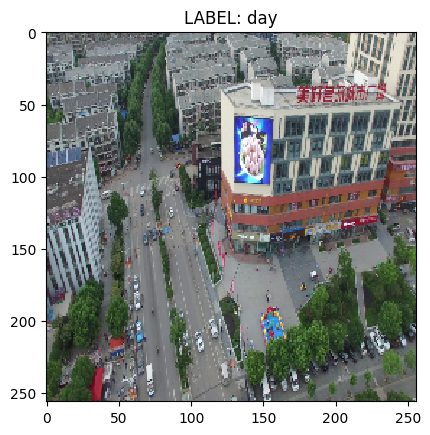


A sample of train set: 


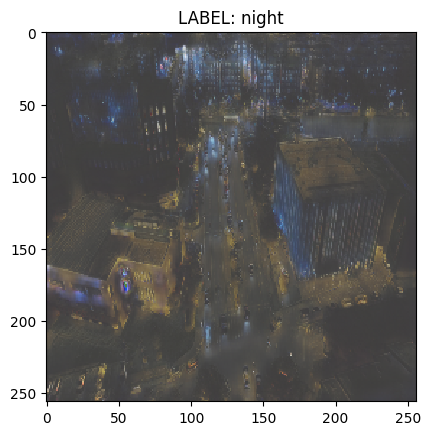

In [19]:
batch_size = 4
labels = ['rain', 'night', 'fog', 'day']
dir_root = '/kaggle/input/weather-datasets/UAVid/UAVid/'
train_ds, test_ds = create_dataset(dir_root = dir_root, batch_size = batch_size, labels = labels)
plot_images(batch_size, labels, train_ds, test_ds)
train_steps = int(tf.data.experimental.cardinality(train_ds).numpy())
test_steps = int(tf.data.experimental.cardinality(test_ds).numpy())

In [20]:
customcnn = CustomCNN().create_model(input_shape=(img_size, img_size, channel), num_classes = len(labels))

MAX_EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.90, max_epochs=MAX_EPOCHS, patience=5)

customcnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [21]:
customcnn_history = customcnn.fit(train_ds, epochs = MAX_EPOCHS, validation_data=test_ds, callbacks=[early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/50
20/20 [==============================] - 5s 50ms/step - loss: 1.7400 - accuracy: 0.4000 - precision_2: 0.4308 - recall_2: 0.3500 - val_loss: 1.3774 - val_accuracy: 0.2500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 1.2035 - accuracy: 0.5000 - precision_2: 0.5593 - recall_2: 0.4125 - val_loss: 1.3972 - val_accuracy: 0.2500 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/50
20/20 [==============================] - 0s 16ms/step - loss: 0.8158 - accuracy: 0.7125 - precision_2: 0.7397 - recall_2: 0.6750 - val_loss: 1.4151 - val_accuracy: 0.2500 - val_precision_2: 1.0000 - val_recall_2: 0.0250
Epoch 4/50
20/20 [==============================] - 0s 16ms/step - loss: 0.6331 - accuracy: 0.7625 - precision_2: 0.7838 - recall_2: 0.7250 - val_loss: 1.4591 - val_accuracy: 0.2500 - val_precision_2: 0.5556 - val_recall_2: 0.2500
Epoch 5/50
20/20 [==============================] - 0s 16ms/

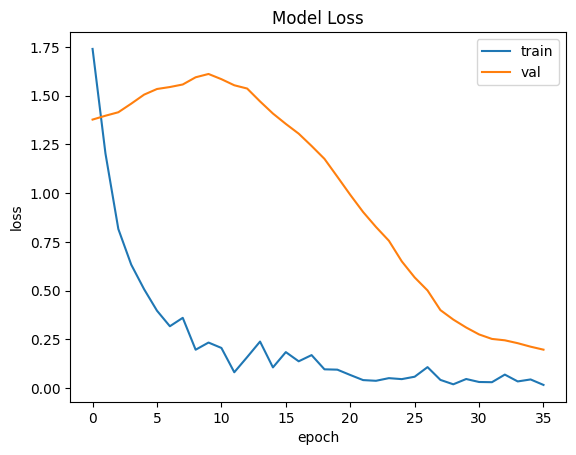

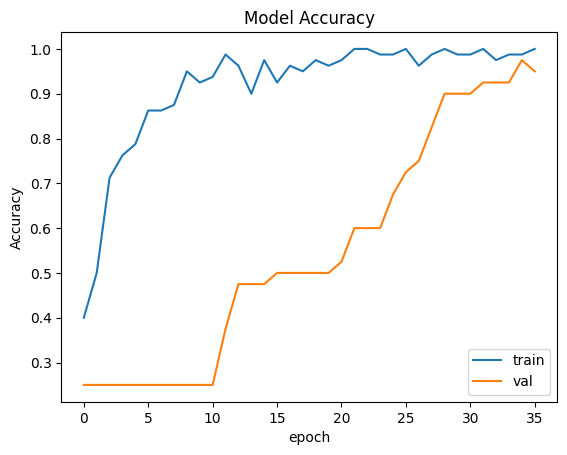

10/10 [==============================] - 1s 4ms/step


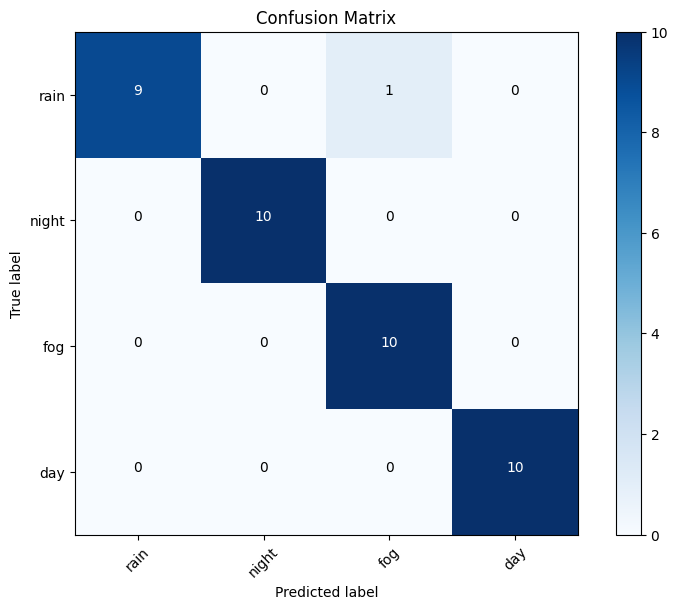

10/10 [==============================] - 0s 6ms/step - loss: 0.2121 - accuracy: 0.9750 - precision_2: 0.9722 - recall_2: 0.8750
Custom CNN classifier evaluation results:

Testset Loss = 0.21214
Testset Accuracy = 0.98
Testset Precision = 0.97
Testset Recall = 0.88


In [22]:
plot_loss_curve(customcnn_history)
plot_accuracy_curve(customcnn_history)
plot_confusion_matrix(customcnn,test_ds,labels, test_steps)
customcnn_score = customcnn.evaluate(test_ds, verbose='auto', steps=test_steps)
print("Custom CNN classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(customcnn_score[0]))
print('Testset Accuracy = {:.2f}'.format(customcnn_score[1]))
print('Testset Precision = {:.2f}'.format(customcnn_score[2]))
print('Testset Recall = {:.2f}'.format(customcnn_score[3]))

# Syndrone

A sample of test set: 


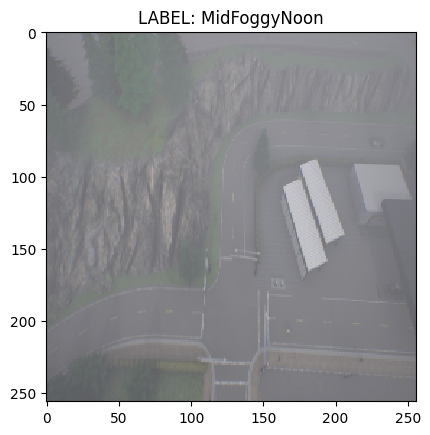


A sample of train set: 


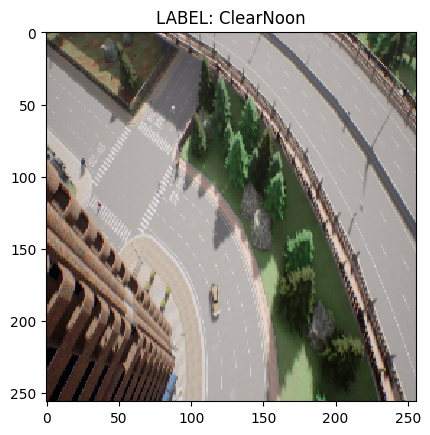

In [23]:
batch_size = 16
labels = ['MidFoggyNoon', 'HardRainNoon', 'ClearNight', 'ClearNoon']
dir_root = '/kaggle/input/weather-datasets/syndrone_weather/syndrone_weather/'
train_ds, test_ds = create_dataset(dir_root = dir_root, batch_size = batch_size, labels = labels)
plot_images(batch_size, labels, train_ds, test_ds)
train_steps = int(tf.data.experimental.cardinality(train_ds).numpy())
test_steps = int(tf.data.experimental.cardinality(test_ds).numpy())

In [24]:
customcnn = CustomCNN().create_model(input_shape=(img_size, img_size, channel), num_classes = len(labels))

MAX_EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_accuracy', threshold=0.95, max_epochs=MAX_EPOCHS, patience=5)

customcnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss= tf.keras.losses.CategoricalCrossentropy(from_logits= False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
customcnn_history = customcnn.fit(train_ds, epochs = MAX_EPOCHS, validation_data=test_ds, callbacks=[early_stopping], steps_per_epoch=train_steps, validation_steps=test_steps, verbose='auto')

Epoch 1/50
50/50 [==============================] - 8s 84ms/step - loss: 0.9953 - accuracy: 0.6812 - precision_3: 0.7188 - recall_3: 0.6612 - val_loss: 1.3698 - val_accuracy: 0.2675 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/50
50/50 [==============================] - 2s 37ms/step - loss: 0.3447 - accuracy: 0.8575 - precision_3: 0.8801 - recall_3: 0.8438 - val_loss: 1.5015 - val_accuracy: 0.2500 - val_precision_3: 0.4255 - val_recall_3: 0.2500
Epoch 3/50
50/50 [==============================] - 2s 37ms/step - loss: 0.1959 - accuracy: 0.9287 - precision_3: 0.9373 - recall_3: 0.9150 - val_loss: 1.6356 - val_accuracy: 0.2500 - val_precision_3: 0.2538 - val_recall_3: 0.2500
Epoch 4/50
50/50 [==============================] - 2s 37ms/step - loss: 0.1581 - accuracy: 0.9425 - precision_3: 0.9481 - recall_3: 0.9362 - val_loss: 1.7386 - val_accuracy: 0.2500 - val_precision_3: 0.2525 - val_recall_3: 0.2500
Epoch 5/50
50/50 [==============================] - 2s 40ms/step - l

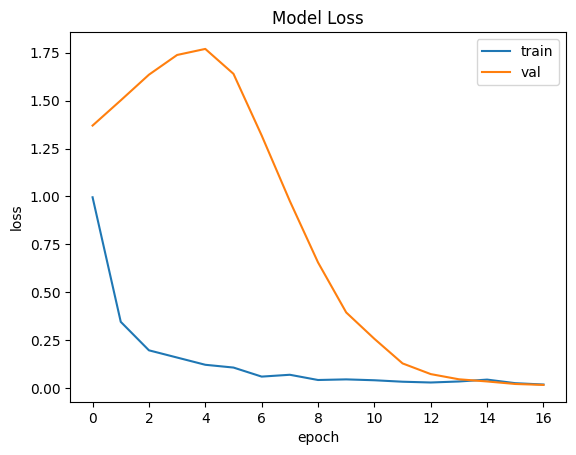

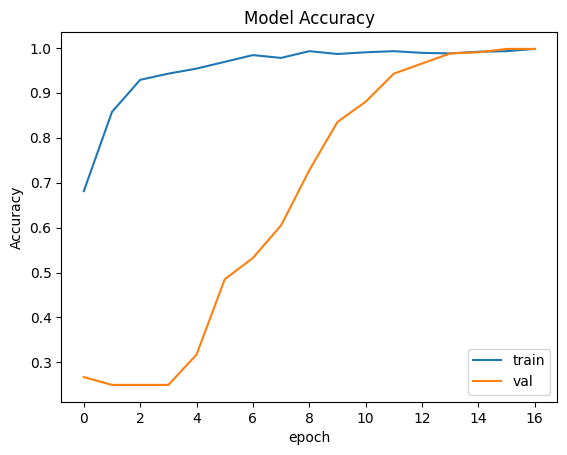

25/25 [==============================] - 0s 11ms/step


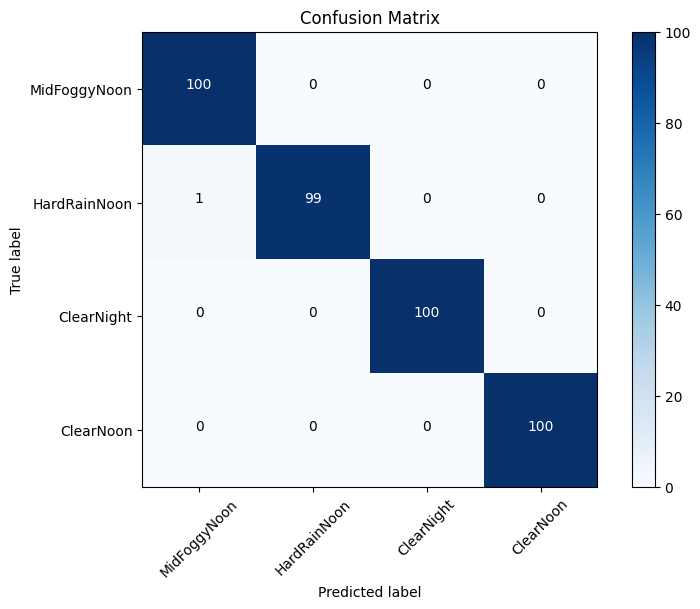

25/25 [==============================] - 0s 14ms/step - loss: 0.0201 - accuracy: 0.9975 - precision_3: 0.9975 - recall_3: 0.9975
Custom CNN classifier evaluation results:

Testset Loss = 0.02008
Testset Accuracy = 1.00
Testset Precision = 1.00
Testset Recall = 1.00


In [26]:
plot_loss_curve(customcnn_history)
plot_accuracy_curve(customcnn_history)
plot_confusion_matrix(customcnn,test_ds,labels, test_steps)
customcnn_score = customcnn.evaluate(test_ds, verbose='auto', steps=test_steps)
print("Custom CNN classifier evaluation results:\n")
print('Testset Loss = {:.5f}'.format(customcnn_score[0]))
print('Testset Accuracy = {:.2f}'.format(customcnn_score[1]))
print('Testset Precision = {:.2f}'.format(customcnn_score[2]))
print('Testset Recall = {:.2f}'.format(customcnn_score[3]))